In [1]:
# Import libraries
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Import preprocessing method
from preprocessing import preprocess

In [3]:
# Define constants
BATCH_SIZE = 128
ENCODED_VECTOR_SIZE = 300
LSTM_SIZE = 100
MAX_WORDS = 10000
NUM_CLASSES = 20
NUM_EPOCHS = 10
OUTPUT_SIZE = 100
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.1

In [4]:
# Load datasets
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
texts = newsgroups.data
labels = newsgroups.target

In [5]:
# Preprocess texts
preprocessed_texts = [preprocess(text) for text in texts]

# Instantiate tokenizer
# tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer = Tokenizer()

# Tokenize words from samples
tokenizer.fit_on_texts(preprocessed_texts)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences 
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences to all be same size
# padded_sequences = pad_sequences(sequences)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, shuffle=True)

In [6]:
# Load in embeddings
embeddings = api.load("word2vec-google-news-300")

# Create embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, index in tokenizer.word_index.items():
    if word in embeddings:
        embedding_matrix[index] = embeddings[word]

In [13]:
# Define CNN model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=ENCODED_VECTOR_SIZE, weights=[embedding_matrix], input_length=ENCODED_VECTOR_SIZE, trainable=False),
    BatchNormalization(),
    Conv1D(BATCH_SIZE, 3, activation="relu"),
    MaxPooling1D(3),
    Conv1D(BATCH_SIZE, 3, activation="relu"),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          44484000  
                                                                 
 conv1d_2 (Conv1D)           (None, 298, 128)          115328    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 97, 128)           49280     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 20)               

In [14]:
# Train the model
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
106/106 [==============================] - 12s 109ms/step - loss: 2.2092 - accuracy: 0.3407 - val_loss: 1.3975 - val_accuracy: 0.5418
Epoch 2/10
106/106 [==============================] - 10s 95ms/step - loss: 1.1587 - accuracy: 0.6369 - val_loss: 1.1201 - val_accuracy: 0.6267
Epoch 3/10
106/106 [==============================] - 12s 114ms/step - loss: 0.8935 - accuracy: 0.7246 - val_loss: 1.0049 - val_accuracy: 0.6757
Epoch 4/10
106/106 [==============================] - 12s 113ms/step - loss: 0.7239 - accuracy: 0.7863 - val_loss: 0.9246 - val_accuracy: 0.6963
Epoch 5/10
106/106 [==============================] - 12s 113ms/step - loss: 0.6009 - accuracy: 0.8283 - val_loss: 0.8878 - val_accuracy: 0.7062
Epoch 6/10
106/106 [==============================] - 12s 112ms/step - loss: 0.4981 - accuracy: 0.8631 - val_loss: 0.8548 - val_accuracy: 0.7308
Epoch 7/10
106/106 [==============================] - 12s 114ms/step - loss: 0.4097 - accuracy: 0.8937 - val_loss: 0.8597 - val_acc

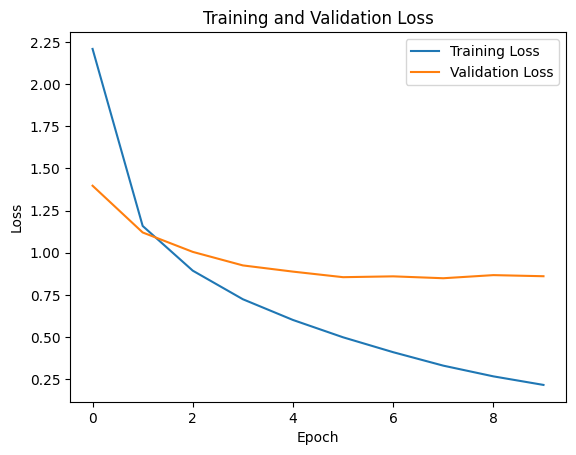

In [15]:
# Plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 1s 10ms/step
Accuracy: 0.7594164456233422
